Get data

In [728]:
file_path = "./data/X.csv"
X = pd.read_csv(file_path)

file_path = "./data/y.csv"
y = pd.read_csv(file_path)


In [729]:
df_org = X.join(y.set_index('id'))

df_mod = df_org

df_mod.set_index('id',inplace= True)

# clear all null lines
for column in df_mod.columns:
    nulls_mask = df_mod[column].notnull()  # or column_with_nulls.isna()
    df_mod = df_mod[nulls_mask]

# drop unnamed columns
df_mod.drop(columns='Unnamed: 0', inplace=True)
df_mod.drop(columns='Unnamed: 0.1',inplace=True)

# removing data point with Gender = 'O'
df_mod = df_mod[df_mod['Gender']!='O']

# setting 'id' column as index
# df_mod.set_index('id', inplace = True)

# deal with categorial columns

label_encoder = LabelEncoder()
for column in df_mod.select_dtypes(include=['object']).columns:
    df_mod[column + '_encoded'] = label_encoder.fit_transform(df_mod[column])

# Train test split
X_train, X_test, y_train, y_test =train_test_split(df_mod.drop(columns = 'Salary'), df_mod.Salary, test_size = 0.3, random_state = 42)

# get all relevant column names
categorical_columns = df_mod.select_dtypes(include=['object']).columns.tolist()

# drop_categorial = True
# if (drop_categorial):
#     df_mod = df_mod.drop(columns=categorical_columns)
# else:
#     # drop some of them
#     categorical_columns_remove = 'Job Title'
#     categorical_columns = [item for item in categorical_columns if item != categorical_columns_remove]


#     df_mod = pd.get_dummies(df_mod,columns = categorical_columns)

# df = df_mod

In [730]:
df_mod

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,Gender_encoded,Education Level_encoded,Job Title_encoded,Country_encoded,Race_encoded
id,,,,,,,,,,,,,,,,
2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,1150.0,90000.0,1,1,3,0,1
76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,1100.0,65000.0,0,0,92,4,9
242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,380.0,200000.0,0,0,136,2,6
5544,34.0,F,master's|degr,marketing|manage,11.0,us,White,2.068465,77.713279,297.0,55000.0,0,4,87,4,9
6017,34.0,F,bachelor's|degr,marketing|manage,9.0,u,White,2.118734,54.683693,256.0,120000.0,0,1,87,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,32.0,F,bachelor,junior|business|development|associat,4.0,canad,Black,2.329507,64.070050,93.0,50000.0,0,0,52,1,3
3677,44.0,M,p,data|scientis,15.0,chin,White,1.945457,93.478548,546.0,120000.0,1,5,19,2,9
6032,25.0,M,high|scho,delivery|drive,1.0,canad,Asian,1.575751,38.216264,0.0,85000.0,1,2,20,1,1


In [731]:
X_train_copy = X_train[['professionalism','Gender_encoded', 'Education Level_encoded', 'Job Title_encoded',
       'Country_encoded', 'Race_encoded']]

In [732]:
# sns.pairplot(df_mod,vars = ['Salary','Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'])



In [733]:
# sns.pairplot(X_train_copy.join(y.set_index('id')), vars = X_train_copy.join(y.set_index('id')).columns, hue = 'Salary')



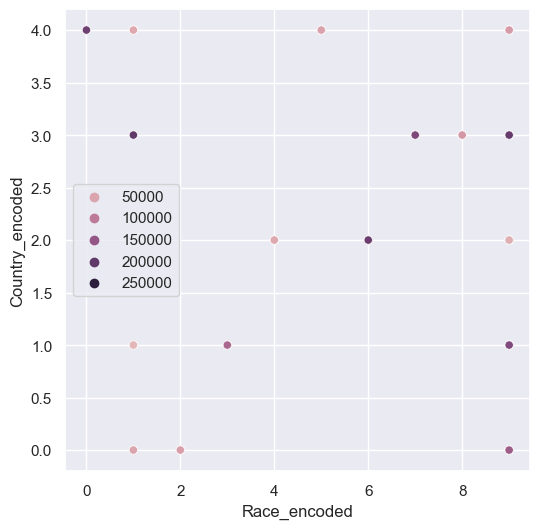

In [734]:
sns.scatterplot(data = X_train.join(y_train),x= 'Race_encoded', y = 'Country_encoded', hue = 'Salary')
plt.legend(loc = 'best')

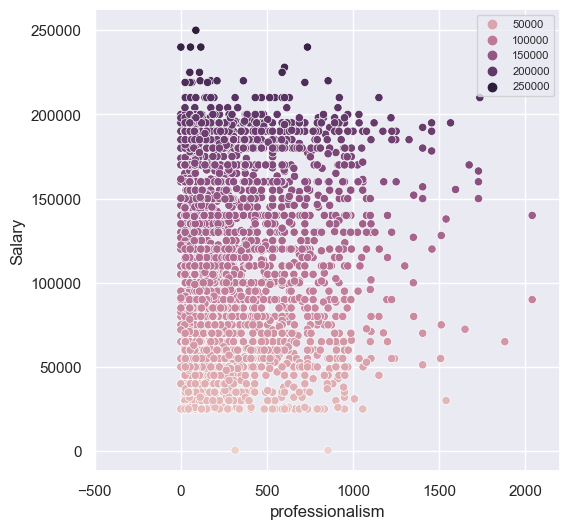

In [735]:
# fig, ax = plt.subplots()
# sns.distplot(data, ax=ax)
# ax.set_xlim(1, 70)
# plt.show()

fig, ax = plt.subplots()
sns.scatterplot(data = X_train.join(y_train),x= 'professionalism', y = 'Salary', hue = 'Salary')
ax.set_xlim(-500, 2200)
plt.legend(loc = 'best', prop={'size':8})
plt.show()

In [736]:
races = X_train['Race_encoded'].unique()
countries = X_train['Country_encoded'].unique()

# sns.pairplot(X_train_copy.join(y), vars = X_train_copy.join(y).columns, hue = 'Salary')

In [737]:
groups.unique().size

17

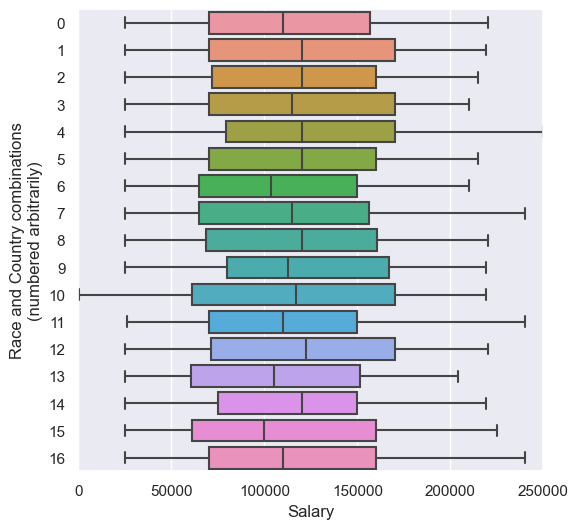

In [738]:
# removing 'Salary' NaN values
data = data[~data['Salary'].isna()]
# grouping by race and country
groups = data.groupby(['Country_encoded', 'Race_encoded']).ngroup()

sns.boxplot(data = data, x = 'Salary', y = groups, orient = 'h').set(ylabel = "Race and Country combinations\n(numbered arbitrarily)", xlim = (0,250000))
# setting sns figure size
sns.set(rc={'figure.figsize':(6,6)})

In [739]:
# The following code performs a Kolmogorov-Smirnov test on these two datasets 
# to determine if they came from the same distribution

from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test

ks_2samp(groups[groups == 12], groups[groups == 15])[1]

# i, j = 0,0
# res = []

# pair-wise distribution, KS test:
# for i in range(len(groups.unique())):
#     for j in range(len(groups.unique())):
#         # print(f"i = {i}, j = {j}")
#         # print(ks_2samp(groups[groups == i], groups[groups == j])[1],'\n')
#         res.append(ks_2samp(groups[groups == i], groups[groups == j])[1])

# printing the KS test p-value, to assess whetehr most distribs are statistically different. Answer = Yes.
# print(res.sort())

1.1151471543020886e-95

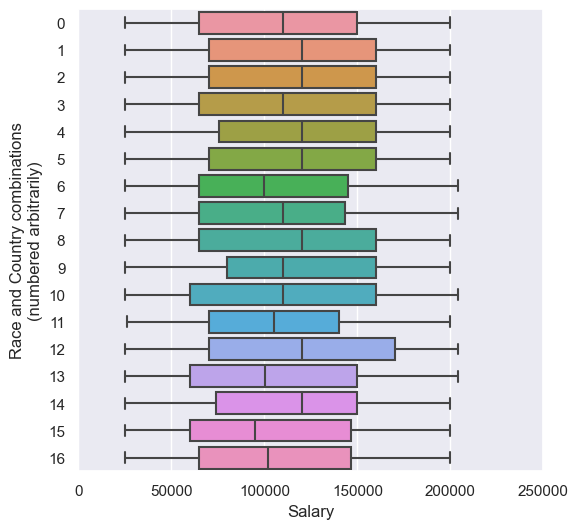

In [740]:
# Filtering out sparse data

data2 = data.loc[(data['professionalism'] < 1001) & (data['Salary'] < 210000) & (data['Salary'] > 10000)] 

# repeating the groupby CountryxRace boxplot analysis:

groups2 = data2.groupby(['Country_encoded', 'Race_encoded']).ngroup()

sns.boxplot(data = data2, x = 'Salary', y = groups2, orient = 'h').set(ylabel = "Race and Country combinations\n(numbered arbitrarily)", xlim = (0,250000))
# setting sns figure size
sns.set(rc={'figure.figsize':(6,6)})

# Data Cleaning decreases intra-group variance and stress inter-groups distrib. differences

In [755]:
from sklearn.metrics import mean_squared_error as mse

def my_fit(X,y):
  X=X.join(y)
  model2 = X.groupby('group_number')[y.name].mean()
  return model2

def my_predict(X,model2):
  y_pred2 = X.group_number.map(model2)
  return y_pred2

def rmsle(y_true: pd.Series, y_pred:pd.Series):
    return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

per train data, model's rmsle based on ['professionalism'] is: 0.212
per test data, model's rmsle based on ['professionalism'] is: 0.308



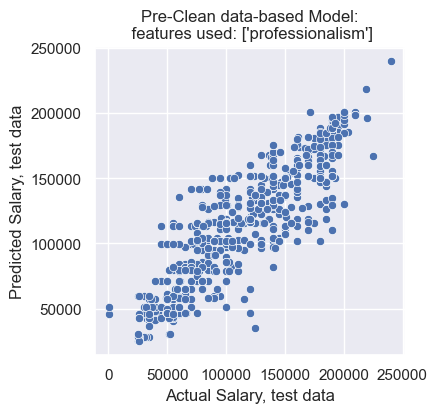



per train data, model's rmsle based on ['professionalism', 'Gender_encoded'] is: 0.192
per test data, model's rmsle based on ['professionalism', 'Gender_encoded'] is: 0.307



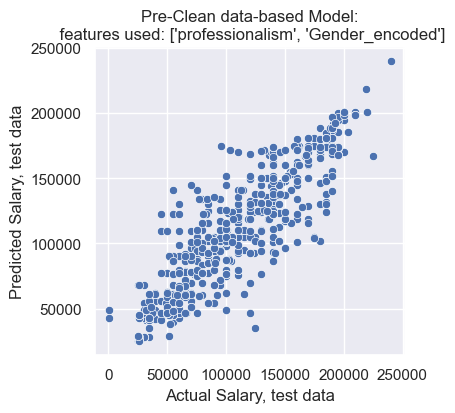



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded'] is: 0.092
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded'] is: 0.2



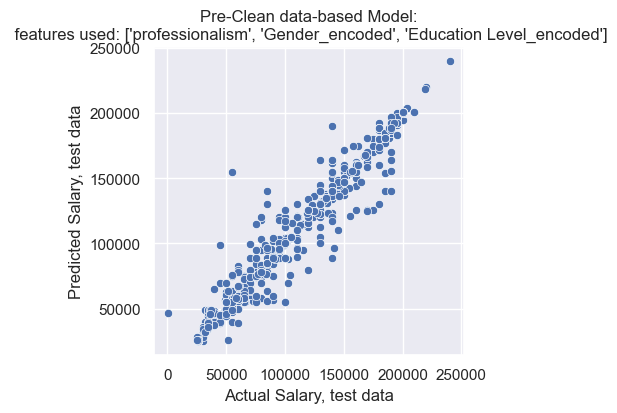



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.02
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.173



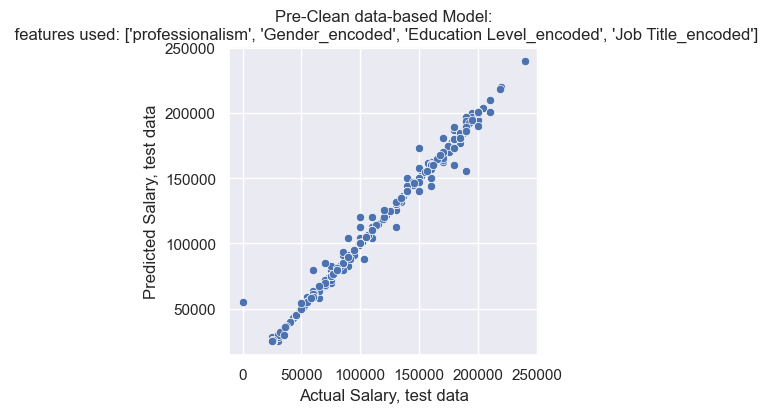



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded'] is: 0.017
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded'] is: 0.218



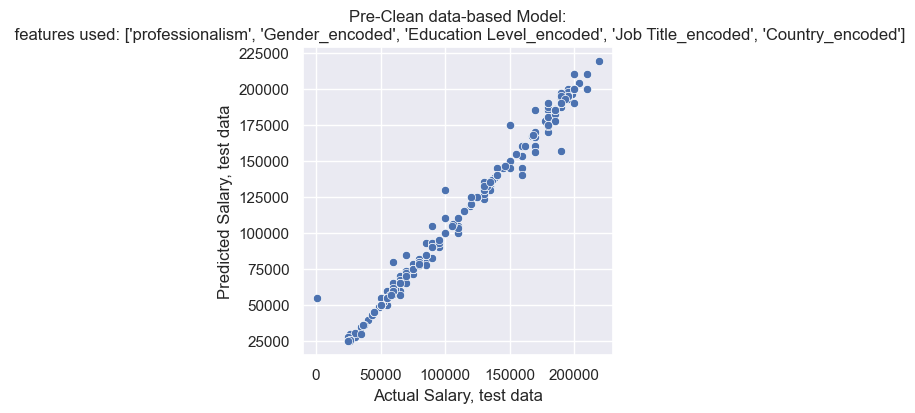



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'] is: 0.012
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'] is: 0.331



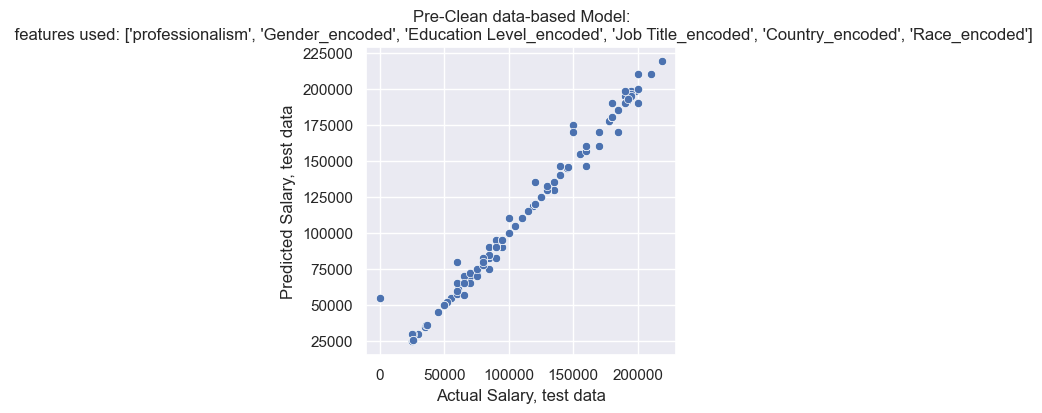

In [1062]:
# custom groupby-based step-wise model, using PRE-CLEANED data (data)

X2 = data.drop(columns = 'Salary')
y2 = data.Salary

for i in range(1,len(X2.columns.values)+1):
    
  # itterate over tested feature combinations
  features = list(X2.columns[:i].values)
  # features = ['Country_encoded', 'Race_encoded']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  X2['group_number'] = X2.groupby(features).ngroup()

  # split the datasets to train and test
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  model2 = my_fit(X2_train,y2_train)

  # predict y (price) per X_test and model2
  y_pred2_train = my_predict(X2_train, model2)  
  y_pred2_test = my_predict(X2_test, model2)

  # calc & print model's rmsle
  rmsle2_train = rmsle(y2_train,y_pred2_train)
  rmsle2_test = rmsle(y2_test,y_pred2_test)

  print(f"per train data, model's rmsle based on {features} is: {rmsle2_train.round(3)}")
  print(f"per test data, model's rmsle based on {features} is: {rmsle2_test.round(3)}\n")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y2_test.values, y = y_pred2_test.values)
  sns.set(rc={'figure.figsize':(4,4)})
  plt.title(f"Pre-Clean data-based Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  plt.show()
  print('\n')

per train data, model's rmsle based on ['professionalism'] is: 0.212
per test data, model's rmsle based on ['professionalism'] is: 0.236


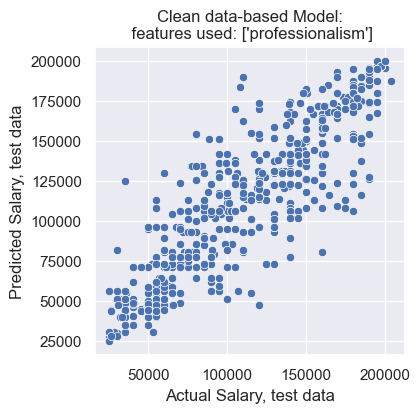



per train data, model's rmsle based on ['professionalism', 'Gender_encoded'] is: 0.195
per test data, model's rmsle based on ['professionalism', 'Gender_encoded'] is: 0.227


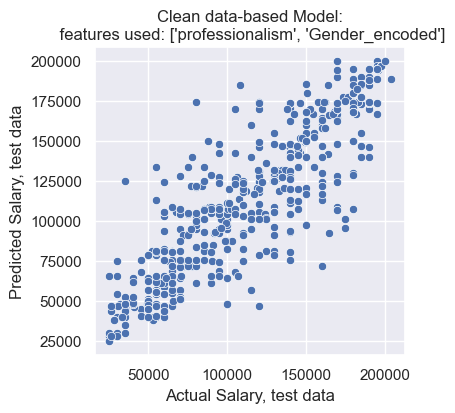



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded'] is: 0.102
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded'] is: 0.112


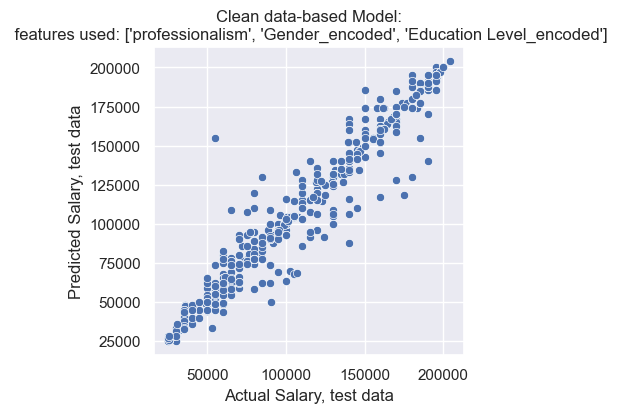



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.022
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.026


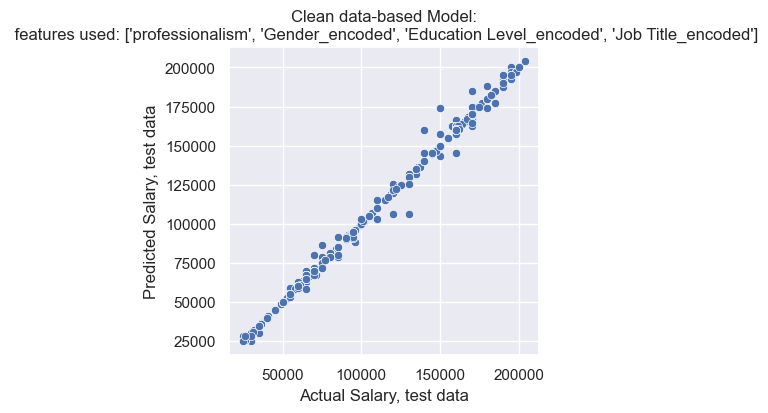



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded'] is: 0.018
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded'] is: 0.035


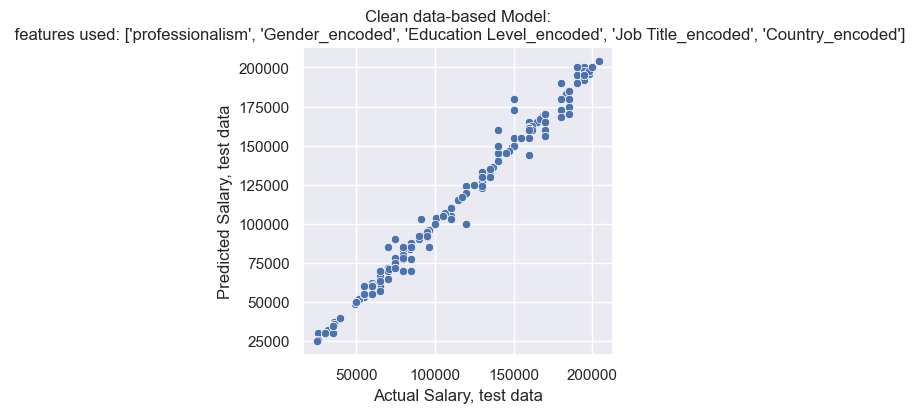



per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'] is: 0.013
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'] is: 0.037


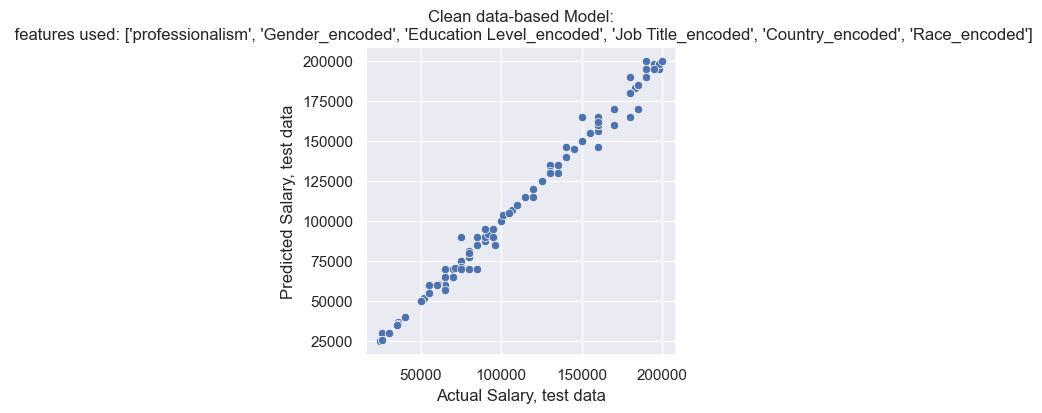

In [1136]:
# custom groupby-based step-wise model, using CLEAN data (data2)

X2 = data2.drop(columns = 'Salary')
y2 = data2.Salary

from sklearn.metrics import mean_squared_error as mse

for i in range(1,len(X2.columns.values)+1):
    
  # itterate over tested feature combinations
  features = list(X2.columns[:i].values)
  # features = ['Country_encoded', 'Race_encoded']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  X2['group_number'] = X2.groupby(features).ngroup()

  # split the datasets to train and test
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  model2 = my_fit(X2_train,y2_train)

  # predict y (price) per X_test and model2
  y_pred2_train = my_predict(X2_train, model2)  
  y_pred2_test = my_predict(X2_test, model2)

  # calc & print model's rmsle
  rmsle2_train = rmsle(y2_train,y_pred2_train)
  rmsle2_test = rmsle(y2_test,y_pred2_test)

  print(f"per train data, model's rmsle based on {features} is: {rmsle2_train.round(3)}")
  print(f"per test data, model's rmsle based on {features} is: {rmsle2_test.round(3)}")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y2_test.values, y = y_pred2_test.values)
  plt.title(f"Clean data-based Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  plt.show()
  print('\n')

per train data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.022
per test data, model's rmsle based on ['professionalism', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded'] is: 0.026


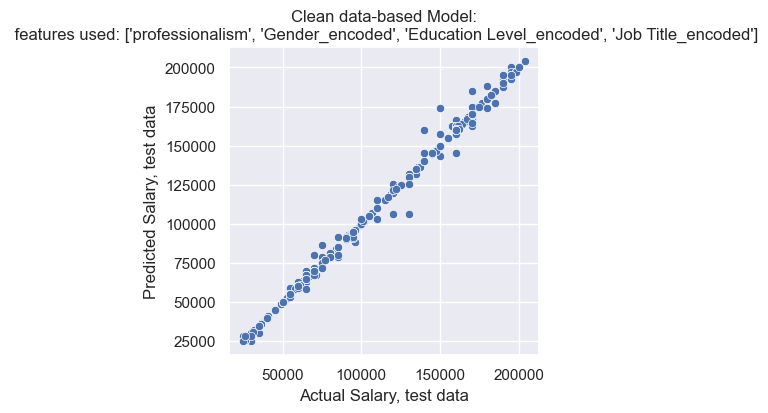

In [1132]:
# testing whether use of all other features (initially neglected) would improve rmsle score

# data3 = data2.join(df_org[['weight']])
# data3 = data2.join(df_org[['Age','Years of Experience','height']])

# recognizing the very high number of nuniques() in 'weight' (and 'height') columns
# data3.groupby(['weight']).ngroup().nunique()

# binning weight
# i = 1
# data3['weight_bins'] = round(data3['weight']/i)*i
# # data3['weight_bins'].nunique()

# # binning height
# i = 0.05
# data3['height_bins'] = round(data3['height']/i)*i
# # data3['height_bins'].nunique()

# custom groupby-based step-wise model, using CLEAN data (data2)

# X2 = data3.drop(columns = ['Salary','height','weight'])

X2 = data2.drop(columns = ['Salary'])
y2 = data2.Salary

from sklearn.metrics import mean_squared_error as mse

# for i in range(1,len(X2.columns.values)+1):
# cancelled the upper iteration and prints only feature combination with 'best' rmsle
for i in range(0,1):
    
  # itterate over tested feature combinations
  # features = list(X2.columns[:i].values)
  features = list(X2.columns[:4].values)
  # features = ['height_bins', 'weight_bins']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  X2['group_number'] = X2.groupby(features).ngroup()

  # split the datasets to train and test
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  model2 = my_fit(X2_train,y2_train)

  # predict y (price) per X_test and model2
  y_pred2_train = my_predict(X2_train, model2)  
  y_pred2_test = my_predict(X2_test, model2)

  # calc & print model's rmsle
  rmsle2_train = rmsle(y2_train,y_pred2_train)
  rmsle2_test = rmsle(y2_test,y_pred2_test)

  print(f"per train data, model's rmsle based on {features} is: {rmsle2_train:.3f}")
  print(f"per test data, model's rmsle based on {features} is: {rmsle2_test:.3f}")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y2_test.values, y = y_pred2_test.values)
  plt.title(f"Clean data-based Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  plt.show()
  print('\n')

In [ ]:
# MY CONCERN##############################################################
# Why there are relatively many NaN values in the 'predicted_test_values'?

# print(y2_test.values, '\n') 
# print(y_pred2_test.values)

In [1133]:
# print(y2_test.values,'\n')
# print(y_pred2_test.values)

In [1137]:
# Validating that this upper finding is random-state-proof
report3, result = [], []

In [1140]:
# # Validating that this upper finding is random-state-proof

# # custom groupby-based step-wise model, using CLEAN data (data2)

# X3 = data2.drop(columns = 'Salary')
# y3 = data2.Salary

# for i in range(1,len(X2.columns.values)+1):
    
#   # itterate over tested feature combinations
#   features = list(X2.columns[:i].values)
#   # features = ['Country_encoded', 'Race_encoded']

#   # split the datasets to train and test while ev through different random states
#   X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state= np.random.randint(100))

#   # create an X Series grouped by chosen features; each unique feature combination is group-numbered
#   X3['group_number'] = X3.groupby(features).ngroup()

#   # create a model per selected features using train data
#   model3 = my_fit(X3_train,y3_train)

#   # predict y (price) per X_test and model2
#   y_pred3_train = my_predict(X3_train, model3)  
#   y_pred3_test = my_predict(X3_test, model3)

#   # calc & print model's rmsle
#   rmsle3_train = rmsle(y3_train,y_pred3_train)
#   rmsle3_test = rmsle(y3_test,y_pred3_test)

#   # make report
#   report3.append((rmsle2_test.round(3)))
#   # index of minimal value
# result.append(report3.index(min(report3)))
# report3 = []

# print(result)

                 
#   # print(f"per train data, model's rmsle based on {features} is: {rmsle2_train.round(3)}")
#   # print(f"per test data, model's rmsle based on {features} is: {rmsle2_test.round(3)}\n")

In [1145]:
# # My Solution - KNN - with Pre-Clean data (data)

X2 = data.drop(columns = 'Salary')
y2 = data.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# n_neighbors = list(range(2,20))

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50]

for weight in weights:
  for leaf in leafs:
    # instantiate class object
    # print(val)
    # print(type(val))
    knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = 'ball_tree', leaf_size = leaf)
    
    # fit
    knr.fit(X2_train,y2_train)
    
    # predict
    y_pred_knn_train = knr.predict(X2_train)
    y_pred_knn_test = knr.predict(X2_test)
    
    # score
    # knr_rmse_train = np.sqrt(mean_squared_error(y2_train, y_pred_knn_train))
    # knr_rmse_test = np.sqrt(mean_squared_error(y2_test, y_pred_knn_test))
    knr_rmsle_train = rmsle(y2_train, y_pred_knn_train)
    knr_rmsle_test = rmsle(y2_test, y_pred_knn_test)
    

    # print coeffiecients
    print(f"When weight equals {weight}:")
    print(f"K-Nearest Neighbour Reg. train model's rmse is {knr_rmsle_train:.2f}")
    print(f"K-Nearest Neighbour Reg. test model's rmse is {knr_rmsle_test:.2f}")
    print(f"rmse_test - rmse_train = {knr_rmsle_test - knr_rmsle_train}\n")

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.26
rmse_test - rmse_train = 0.127413443912094

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.26
rmse_test - rmse_train = 0.12691545499950757

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.26
rmse_test - rmse_train = 0.12691545499950757

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.26
rmse_test - rmse_train = 0.12690135334312844

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.26
rmse_test - rmse_train = 0.12690135334312844

When weight equals distance:
K-Nearest Neighbour Reg. train model's rmse is 0.01
K-Nearest Neighbour Reg. test model'

In [1144]:
# # My Solution - KNN - Now with Clean data2

X2 = data2.drop(columns = 'Salary')
y2 = data2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# n_neighbors = list(range(2,20))

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50]

for weight in weights:
  for leaf in leafs:
    # instantiate class object
    # print(val)
    # print(type(val))
    knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = 'ball_tree', leaf_size = leaf)
    
    # fit
    knr.fit(X2_train,y2_train)
    
    # predict
    y_pred_knn_train = knr.predict(X2_train)
    y_pred_knn_test = knr.predict(X2_test)
    
    # score
    # knr_rmse_train = np.sqrt(mean_squared_error(y2_train, y_pred_knn_train))
    # knr_rmse_test = np.sqrt(mean_squared_error(y2_test, y_pred_knn_test))
    knr_rmsle_train = rmsle(y2_train, y_pred_knn_train)
    knr_rmsle_test = rmsle(y2_test, y_pred_knn_test)
    

    # print coeffiecients
    print(f"When weight equals {weight}:")
    print(f"K-Nearest Neighbour Reg. train model's rmse is {knr_rmsle_train:.2f}")
    print(f"K-Nearest Neighbour Reg. test model's rmse is {knr_rmsle_test:.2f}")
    print(f"rmse_test - rmse_train = {knr_rmsle_test - knr_rmsle_train}\n")

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.17
rmse_test - rmse_train = 0.03145625168443078

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.17
rmse_test - rmse_train = 0.03152881178094041

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.17
rmse_test - rmse_train = 0.03255388395100686

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.17
rmse_test - rmse_train = 0.03255388395100686

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 0.14
K-Nearest Neighbour Reg. test model's rmse is 0.17
rmse_test - rmse_train = 0.03255388395100686

When weight equals distance:
K-Nearest Neighbour Reg. train model's rmse is 0.01
K-Nearest Neighbour Reg. test mode

In [1149]:
# Decision Tree Regressor - My Solution with Clean data (data2)

X2 = data2.drop(columns = 'Salary')
y2 = data2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

min_samples_split = list(range(2,50+1,5))

for val in min_samples_split:
  # instantiate class object
  dtr = DecisionTreeRegressor(min_samples_split = val)

  # fit
  dtr.fit(X2_train, y2_train)

  # predict
  y_pred_train_dtr = dtr.predict(X2_train)
  y_pred_test_dtr = dtr.predict(X2_test)


  # score
  dtr_train_rmsle = rmsle(y2_train, y_pred_train_dtr)
  dtr_test_rmsle = rmsle(y2_test, y_pred_test_dtr)
    
  # print scoring stats
  print(f"When minimal samples split equals {val}:")
  print(f"Decision Tree reg. training model's rmse is {dtr_train_rmsle:.4f}")
  print(f"Decision Tree reg. test model's rmse is {dtr_test_rmsle:.4f}")
  print(f"the difference between train's and test's rmse's is {dtr_test_rmsle - dtr_train_rmsle:.2f}\n")  

When minimal samples split equals 2:
Decision Tree reg. training model's rmse is 0.0128
Decision Tree reg. test model's rmse is 0.1392
the difference between train's and test's rmse's is 0.13

When minimal samples split equals 7:
Decision Tree reg. training model's rmse is 0.0413
Decision Tree reg. test model's rmse is 0.1350
the difference between train's and test's rmse's is 0.09

When minimal samples split equals 12:
Decision Tree reg. training model's rmse is 0.0637
Decision Tree reg. test model's rmse is 0.1527
the difference between train's and test's rmse's is 0.09

When minimal samples split equals 17:
Decision Tree reg. training model's rmse is 0.0818
Decision Tree reg. test model's rmse is 0.1537
the difference between train's and test's rmse's is 0.07

When minimal samples split equals 22:
Decision Tree reg. training model's rmse is 0.0931
Decision Tree reg. test model's rmse is 0.1550
the difference between train's and test's rmse's is 0.06

When minimal samples split equal

In [1161]:
# Lasso/ridge Linear regression - With Clean data (data2) 
# Nothing to write home about ###########################

X2 = data2.drop(columns = 'Salary')
y2 = data2.Salary

# split the datasets to train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# define alphas to interate through
# alphas = [0.000001, 0.01, 0.1,1, 10,100, 1000,10000]
alphas = [0.000001, 0.01, 0.1,1, 10,100, 10000, 100000, 1000000, 10000000]

from sklearn.linear_model import LinearRegression, Lasso, Ridge

for alpha in alphas:
  # print(alpha)
  # instantiate class object
  lasso = Lasso(alpha = alpha)
  ridge = Ridge(alpha = alpha)

  # fit
  lasso.fit(X2_train, y2_train)
  ridge.fit(X2_train, y2_train)

  # predict
  y_pred_lasso_train = lasso.predict(X2_train)
  y_pred_ridge_train = ridge.predict(X2_train)
  y_pred_lasso_test = lasso.predict(X2_test)
  y_pred_ridge_test = ridge.predict(X2_test)

  # score
  lasso_rmsle_train = rmsle(y2_train, y_pred_lasso_train)
  ridge_rmsle_train = rmsle(y2_train, y_pred_ridge_train)
  lasso_rmsle_test = rmsle(y2_test, y_pred_lasso_test)
  ridge_rmsle_test = rmsle(y2_test, y_pred_ridge_test)

  # print coeffiecients
  print(f'for alpha = {alpha}:')
  print(f"lasso rmsle train is {lasso_rmsle_train:.3f} and test rmsle is {lasso_rmsle_test:.3f}")
  print(f"ridge rmsle train is {ridge_rmsle_train:.3f} and test rmsle is {ridge_rmsle_test:.3f}\n")

  # print(f"and features {X_train[['Country_encoded','Race_encoded']].columns.values}:")
  # print(f"lasso coefficients are: {lasso.coef_}")
  # print(f"ridge coefficients are: {ridge.coef_}\n")

for alpha = 1e-06:
lasso rmsle train is 0.354 and test rmsle is 0.366
ridge rmsle train is 0.354 and test rmsle is 0.366

for alpha = 0.01:
lasso rmsle train is 0.354 and test rmsle is 0.366
ridge rmsle train is 0.354 and test rmsle is 0.366

for alpha = 0.1:
lasso rmsle train is 0.354 and test rmsle is 0.366
ridge rmsle train is 0.354 and test rmsle is 0.366

for alpha = 1:
lasso rmsle train is 0.354 and test rmsle is 0.366
ridge rmsle train is 0.354 and test rmsle is 0.366

for alpha = 10:
lasso rmsle train is 0.354 and test rmsle is 0.366
ridge rmsle train is 0.354 and test rmsle is 0.366

for alpha = 100:
lasso rmsle train is 0.354 and test rmsle is 0.366
ridge rmsle train is 0.354 and test rmsle is 0.366

for alpha = 10000:
lasso rmsle train is 0.354 and test rmsle is 0.365
ridge rmsle train is 0.354 and test rmsle is 0.365

for alpha = 100000:
lasso rmsle train is 0.357 and test rmsle is 0.368
ridge rmsle train is 0.354 and test rmsle is 0.365

for alpha = 1000000:
lasso rmsle tr